In [13]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

%matplotlib inline

In [14]:
"""
    Download the data and apply the following transformation for data pre-processing and argmentation
    
    transforms.ToTensor() -> convert the image to [0, 1]
    transforms.Normalize() -> normalize the image to [-1, 1] (image = (image - mean) / std)
"""

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [15]:
"""
    Randomly shuffle and load the data with batch size = 64
"""
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = True)


(242, 242, 3)


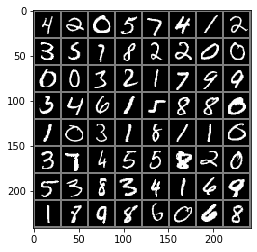

In [16]:
images, labels = next(iter(train_loader))

img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1,2,0) # switch the channel 0 -> 1, 1 -> 2, 2 -> 0
print(img.shape)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean

plt.imshow(img)

In [17]:
"""
    Set up the network structure (example from the official website)
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
# parameter
learning_rate = 0.001 # learning rate 
n_epoch = 20
momentum = 0.9
use_gpu = torch.cuda.is_available()

# model creation
net = Net().cuda() if(use_gpu) else Net()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum) # optimizer


print(use_gpu)
print(net)

True
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [39]:
"""
    Model Training 
"""
def train(n_epoch, use_gpu):
    stats = dict()
    stats["training_loss"] = list()
    stats["training_accuracy"] = list()
    stats["testing_accuracy"] = list()

    for epoch in range(n_epoch):
        print("Epoch {}/{}".format(epoch + 1, n_epoch))
        print("-"*10)

        running_loss = 0.0
        running_correct = 0
        
        for data in train_loader:
            images, labels = data

            # For nn.NLLLoss, the data type should be torch.long, as it is probability
            labels = labels.type(torch.LongTensor);
            
            # put the training data to GPU if it is allowed
            if(use_gpu):
                images = images.cuda()
                labels = labels.cuda()

            # zero the parameter gradient for each batch
            optimizer.zero_grad();

            # forward propagation
            outputs = net(images)

            _,pred = torch.max(outputs.data, 1)

            # evaluate the loss
            loss = criterion(outputs, labels)
            # backward propagation
            loss.backward()
            # update all the parameter
            optimizer.step()

            running_correct += torch.sum(pred == labels.data)

            running_loss += loss.item() * images.size(0)

        testing_correct = 0
        for data in test_loader:
            images, labels = data

            if(use_gpu):
                images = images.cuda()
                labels = labels.cuda()

            outputs = net(images)
            _, pred = torch.max(outputs.data, 1)
            testing_correct += torch.sum(pred == labels.data)
        
        print("Loss: {:.4f}, Train Accuracy: {:.4f}%, Test Accuracy: {:.4f}"
            .format(running_loss/(len(train_loader) * batch_size),
                    100 * running_correct/(len(train_loader) * batch_size),
                    100 * testing_correct/(len(test_loader) * batch_size)
            ))

        stats["training_loss"].append(running_loss/(len(train_loader) * batch_size))
        stats["training_accuracy"].append(running_correct/(len(train_loader)  * batch_size))
        stats["testing_accuracy"].append(testing_correct/(len(test_loader)  * batch_size))

    torch.save(model.state_dict(), './model/')
    return stats

In [40]:
train(3, use_gpu)

Epoch 1/3
----------
Loss: 0.0280, Train Accuracy: 99.0000%, Test Accuracy: 98.0000
tensor(59493, device='cuda:0')
60032
tensor(99, device='cuda:0')
Epoch 2/3
----------
Loss: 0.0269, Train Accuracy: 99.0000%, Test Accuracy: 98.0000
tensor(59511, device='cuda:0')
60032
tensor(99, device='cuda:0')
Epoch 3/3
----------
Loss: 0.0263, Train Accuracy: 99.0000%, Test Accuracy: 98.0000
tensor(59517, device='cuda:0')
60032
tensor(99, device='cuda:0')


{'training_loss': [0.02803565493064013,
  0.026851855305784038,
  0.02626620861354159],
 'training_accuracy': [tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0')],
 'testing_accuracy': [tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0'),
  tensor(0, device='cuda:0')]}